# Libs

In [42]:

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors

import numpy as np

import os
import re
import sys

import seaborn as sns
 
from pytictoc import TicToc
t = TicToc()
    
from collections import defaultdict
    
sys.path.append("/home/charles/Projects/BarycentersAgePyramid/Python")

import pickle


from WassAge import *

from pathlib import Path

# Params

In [43]:
DATA_PATH = Path("." ) / ".." / ".." / "Data" 
os.listdir(DATA_PATH)

['Numpy',
 'shpMtlDAAgePyramid',
 'QuebecNeighbourhoods',
 '.ipynb_checkpoints',
 'MontrealNeighbourhoods',
 'shpQcDAAgePyramid',
 'Extremal']

In [44]:
np.random.seed(1)

In [45]:
useApproxWass= False
approxStr = "Approximate"  if useApproxWass else "Exact"

In [46]:
#city= "Montreal"
city= "Quebec City"

# Data IO

## DA shp

In [47]:
dfGeoClean = normalizeCleanDfGeo( readDAShp(city=city) )
dfGeoClean.head(2)

Reading neibourhoods from Quebec City


ShapeAr Type  Dwllngs  Hoshlds    GeoUID  Popultn CD_UID  CSD_UID  \
0  0.03739   DA      390      367  24230282      578   2423  2423027   
1  0.17787   DA      364      361  24230583      584   2423  2423027   

       CT_UID CMA_UID  ...     80_84     85_89  90_94  95_99  100_+    ID  \
0  4210011.00   24421  ...  0.035714  0.008929    0.0    0.0    0.0  31.0   
1  4210113.01   24421  ...  0.071429  0.053571    0.0    0.0    0.0  18.0   

                    NOM     SUPERFI  PERIMET  \
0         Saint-Sauveur  3974715.39  14978.5   
1  Pointe-de-Sainte-Foy  4251524.43  12888.9   

                                            geometry  
0  POLYGON ((-208624.8003297645 316568.9436800948...  
1  POLYGON ((-214807.2264055035 311855.7902562238...  

[2 rows x 38 columns]

In [48]:
dfGeoClean[LIST_AGE_COLS].sum(axis=1)

0      1.0
1      1.0
2      1.0
3      1.0
4      1.0
      ... 
878    1.0
879    1.0
880    1.0
881    1.0
882    1.0
Length: 879, dtype: float64

In [49]:
dfGeoCleanAge = dfGeoClean[LIST_AGE_COLS]

In [50]:
subsetRows=min( 900, dfGeoClean.shape[0])

## Neigh

In [51]:
dfNeigh = readNeighShp(city=city)

Reading neibourhoods from Quebec City


# Dist matrix

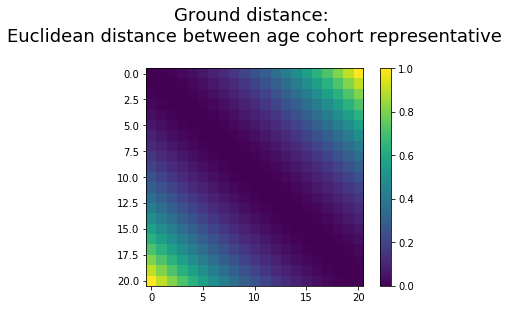

In [52]:
distMatrix = getDistanceAgeCohorts()
f=plt.figure()
plt.imshow(distMatrix)
plt.colorbar()
plt.title("Ground distance: \nEuclidean distance between age cohort representative\n",fontsize=18)

 
f.savefig( DATA_PATH /   ".."/ "Figures" / f"groundDistance.png", bbox_inches="tight")


# Wasserstein barycenter - city wide

In [53]:
def computeWass():
    t.tic()
    dictPar={"solver":"glpk"}
    bary_wass = getWassBarycenter(dfGeoClean[LIST_AGE_COLS][:subsetRows], 
                                  distMatrix, 
                                  approx=useApproxWass,
                                  verbose=True,
                                  extraParams=dictPar)
    t.toc()
    totalSecsToSolve = t.tocvalue()
    print(totalSecsToSolve/(60*60) )
    
    return bary_wass

In [54]:
subsetRows
os.path.exists(pathWass)
os.path.exists( Path(".") /".."  / ".." / "Data" / "Numpy" )

True

### Save the array for faster loading later

In [55]:
f"cityWideDAWassBarycenter_{subsetRows}_{city}.pickle"

'cityWideDAWassBarycenter_879_Quebec City.pickle'

In [56]:
pathWass= Path(".") /".."  / ".." / "Data" / "Numpy" / f"cityWideDAWassBarycenter_{subsetRows}_{city}.pickle"

if os.path.exists(pathWass):
    print(f"Wass exists for params:{subsetRows}_{city} reading it")
    
    with open(pathWass, "rb") as f:
        bary_wass= pickle.load(f)

else:
    bary_wass=computeWass()

    with open(pathWass, "wb") as f:
        pickle.dump(bary_wass , f)

Wass exists for params:879_Quebec City reading it


In [57]:
dfGeoClean.shape[0] 

879

# Euclidean barycenter (arithmetic mean) - city wide

In [58]:
dfEuclMean = getEuclideanBarycenter(dfGeoClean[:subsetRows])
dfEuclMean

0_4       5_9     10_14     15_19     20_24     25_29     30_34  \
0  0.048142  0.046909  0.041237  0.045045  0.071156  0.073475  0.067015   

      35_39     40_44     45_49  ...     55_59     60_64     65_69     70_74  \
0  0.066055  0.055095  0.056614  ...  0.079735  0.073715  0.066787  0.052704   

      75_79     80_84     85_89     90_94     95_99     100_+  
0  0.035296  0.025001  0.016002  0.005408  0.001824  0.000248  

[1 rows x 21 columns]

# Plot and compare

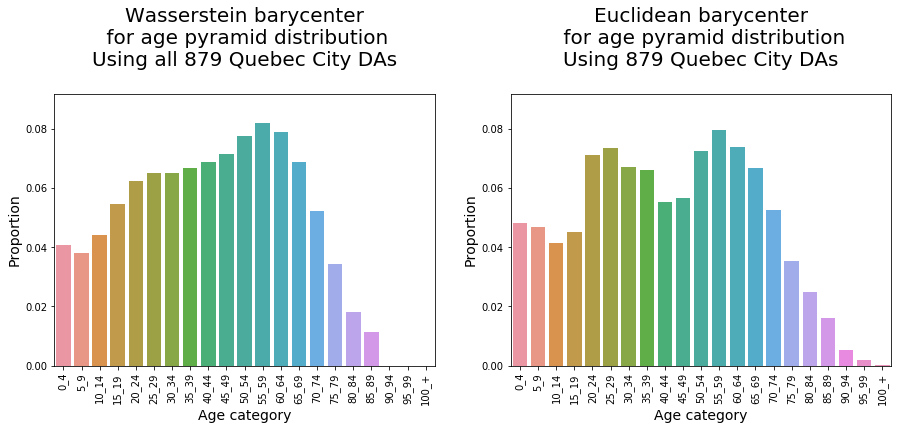

In [59]:
f=plt.figure(figsize=(15,5))
maxY=max(max(bary_wass), max(dfEuclMean.iloc[0,:].values))+0.01

#_ = f.suptitle("Age pyramid barycenters under different distances", y=0.99)

ax=plt.subplot(1,2,1)
plt.ylim(0,maxY)
ax=sns.barplot( x=dfEuclMean.columns, y=bary_wass,ax=ax)
ax.set_title(f"Wasserstein barycenter\n for age pyramid distribution\nUsing all {subsetRows} {city} DAs\n", fontsize=20)
_ = ax.set_xticklabels(labels= dfEuclMean.columns, rotation=90)
ax.set_ylabel("Proportion", fontsize=14)
ax.set_xlabel("Age category", fontsize=14)

ax=plt.subplot(1,2,2)
plt.ylim(0,maxY)
ax=sns.barplot( x=dfEuclMean.columns, y=dfEuclMean.iloc[0,:].values,ax=ax)
ax.set_title(f"Euclidean barycenter\n for age pyramid distribution\nUsing {subsetRows} {city} DAs\n", fontsize=20)
_ = ax.set_xticklabels(labels= dfEuclMean.columns, rotation=90)
ax.set_ylabel("Proportion", fontsize=14)
ax.set_xlabel("Age category", fontsize=14)
 
f.savefig( Path(DATA_PATH) / ".." / "Figures" / "ByCity" /  f"qcOverallWassVsEuclidean_{subsetRows}_{city}.png", bbox_inches="tight")
